# January, 13th 2020

**Motivation**: Combining datasets using CanonicalCorrelation Analysis (CCA). Can we find latent dimensions using CCA that is shared between different datasets, and then map data from neuron space to this shared latent space?<br>
**Result**: Not yet clear, some preliminary results show that this is possible.  However, thorough analysis is needed to understand this shared space.  It still doesn't work convincingly.

In [1]:
# HIDE CODE


# imports
import os
import sys
import h5py
import pickle
import random
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.generic_utils import *
from utils.plot_functions import *

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import rcca
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

# load data
dirs_dict = get_dirs()

## CCA analysis

TODO

In [2]:
from typing import Tuple, Union

def _load_target_nontarget(h_load_file: str):
    target_dffs, nontarget_dffs = {}, {}
    target_labels, nontarget_labels = {}, {}
    target_freqs, nontarget_freqs = {}, {}
    
    f = h5py.File(h_load_file, 'r')
    for name in f:
        behavior = f[name]['behavior']
        passive = f[name]['passive']

        good_cells_b = np.array(behavior["good_cells"], dtype=int)
        good_cells_p = np.array(passive["good_cells"], dtype=int)
        good_cells = set(good_cells_b).intersection(set(good_cells_p))
        good_cells = sorted(list(good_cells))

        dff = np.array(behavior['dff'], dtype=float)[..., good_cells]
        nt, ntrials, nc = dff.shape

        trial_info = {}
        for k, v in behavior["trial_info"].items():
            trial_info[k] = np.array(v, dtype=int)
        
        target_indxs = np.where(trial_info['target'])[0]
        nontarget_indxs = np.where(trial_info['nontarget'])[0]

        target_dffs[name] = dff[:, target_indxs, :]
        nontarget_dffs[name] = dff[:, nontarget_indxs, :]

        target_labels[name] = trial_info['hit'][target_indxs]
        nontarget_labels[name] = trial_info['correctreject'][nontarget_indxs]
        
        target_freqs[name] = trial_info['stimfrequency'][target_indxs]
        nontarget_freqs[name] = trial_info['stimfrequency'][nontarget_indxs]
    f.close()
    
    raw_data = {
        'target_dffs': target_dffs,
        'nontarget_dffs': nontarget_dffs,
        'target_labels': target_labels,
        'nontarget_labels': nontarget_labels,
        'target_freqs': target_freqs,
        'nontarget_freqs': nontarget_freqs,
    }
    return raw_data


def train_test_split(n_samples: int, xv_folds: int = 5, which_fold: int = 0):
    which_fold = which_fold % xv_folds
    num_tst_indxs = int(np.floor(n_samples / xv_folds))
    
    start = which_fold * num_tst_indxs
    stop = min((which_fold + 1) * num_tst_indxs, n_samples)
    tst_indxs = range(start, stop)
    trn_indxs = np.delete(np.arange(n_samples), tst_indxs)

    assert not set(tst_indxs).intersection(set(trn_indxs))
    return tst_indxs, trn_indxs


#def normalize_global(d: dict):
#    global_mean = np.mean([item.std() for item in d.values()])
#    global_std = np.mean([item.std() for item in d.values()])
    
##    normalized = {
#        k: (v - global_mean) / global_std
#        for k,v in d.items()
#    }
#    return normalized

In [3]:
def prepare_data(
    raw_data: dict,
    target: bool = True,
    normalize: bool = True,
    xv_folds: int = 5,
    which_fold: int = 0,
    time_range: range = range(45, 46),
    verbose: bool = False, ):
    
    key_dff = 'target_dffs' if target else 'nontarget_dffs'
    key_label = 'target_labels' if target else 'target_labels'
    key_freq = 'target_freqs' if target else 'target_freqs'
    
    unique_labels = np.unique(list(raw_data[key_label].values())[0])
    unique_freqs = np.unique(list(raw_data[key_freq].values())[0])
    
    selected_names = [
        'scabbers_2016-08-31',
        'scabbers_2016-09-07',
        'scabbers_2016-09-22',
        'scabbers_2016-09-23',
        'scabbers_2016-09-28',
    ]

    trn, tst = {}, {}
    df_trn, df_tst = pd.DataFrame(), pd.DataFrame()

    global_sds, global_means = [], []
    for name in selected_names:
        dff = raw_data[key_dff][name]
        label = raw_data[key_label][name]
        freq = raw_data[key_freq][name]

        if verbose:
            print(name, dff.shape)

        _trn, _tst = [], []
        _df_trn, _df_tst = pd.DataFrame(), pd.DataFrame()

        for ll in unique_labels:
            for ff in unique_freqs:
                _idxs = np.where((label == ll) & (freq == ff))[0]
                global_sds.append(np.std(dff[time_range]))
                global_means.append(np.std(dff[time_range]))
                
                tst_indxs, trn_indxs = train_test_split(len(_idxs), xv_folds=xv_folds, which_fold=which_fold)
                _tst.append(dff[time_range][:, tst_indxs, :])
                _trn.append(dff[time_range][:, trn_indxs, :])

                timepoint = np.expand_dims(time_range, 1)
                data_dict_tst = {
                    'timepoint': np.repeat(timepoint, len(tst_indxs), axis=1).flatten(),
                    'name': [name] * len(tst_indxs) * len(time_range),
                    'label': [ll] * len(tst_indxs) * len(time_range),
                    'freq': [ff] * len(tst_indxs) * len(time_range),
                }
                data_dict_trn = {
                    'timepoint': np.repeat(timepoint, len(trn_indxs), axis=1).flatten(),
                    'name': [name] * len(trn_indxs) * len(time_range),
                    'label': [ll] * len(trn_indxs) * len(time_range),
                    'freq': [ff] * len(trn_indxs) * len(time_range),
                }
                _df_tst = pd.concat([_df_tst, pd.DataFrame.from_dict(data_dict_tst)])
                _df_trn = pd.concat([_df_trn, pd.DataFrame.from_dict(data_dict_trn)])

        tst[name] = np.concatenate(_tst, axis=1)
        trn[name] = np.concatenate(_trn, axis=1)
        df_tst = pd.concat([df_tst, _df_tst])
        df_trn = pd.concat([df_trn, _df_trn])
        
    if normalize:
        global_sd = np.mean(global_sds)
        global_mean = np.mean(global_means)
        trn = {k: (v - global_mean) / global_sd for k, v in trn.items()}
        tst = {k: (v - global_mean) / global_sd for k, v in tst.items()}

    output_trn = {'data': trn, 'df': df_trn}
    output_tst = {'data': tst, 'df': df_tst}
    return output_trn, output_tst

In [4]:
raw_data = _load_target_nontarget(dirs_dict['h_load_file'])

trn, tst = prepare_data(
    raw_data=raw_data,
    target=True,
    normalize=True,
    xv_folds=5,
    which_fold=0,
    time_range=range(45, 46),
    verbose=True,
)

scabbers_2016-08-31 (135, 100, 67)
scabbers_2016-09-07 (135, 124, 65)
scabbers_2016-09-22 (135, 133, 73)
scabbers_2016-09-23 (135, 110, 62)
scabbers_2016-09-28 (135, 134, 52)


In [5]:
[item.shape for item in trn['data'].values()]

[(1, 81, 67), (1, 101, 65), (1, 108, 73), (1, 89, 62), (1, 109, 52)]

In [6]:
global_mean = np.mean([item.std() for item in trn['data'].values()])
global_std = np.mean([item.std() for item in trn['data'].values()])
global_mean, global_std

(1.01029751545895, 1.01029751545895)

In [7]:
def _get_xy(trn, tst):
    num_tst = min([item.shape[1] for item in tst['data'].values()])
    num_trn = min([item.shape[1] for item in trn['data'].values()])
    train_list = [item[:, :num_trn, :].reshape(-1, item.shape[-1]) for item in trn['data'].values()]
    test_list = [item[:, :num_tst, :].reshape(-1, item.shape[-1]) for item in tst['data'].values()]

    train_labels_list = [
        trn['df'].loc[trn['df'].name == name].label.tolist()[:num_trn]
        for name in trn['data'].keys()]
    test_labels_list = [
        tst['df'].loc[tst['df'].name == name].label.tolist()[:num_tst]
        for name in tst['data'].keys()]

    y_trn, y_tst = tuple(map(np.concatenate, [train_labels_list, test_labels_list]))
    
    return train_list, y_trn, test_list, y_tst

In [8]:
train_list, y_trn, test_list, y_tst = _get_xy(trn, tst)
y_trn.shape, y_tst.shape

((405,), (95,))

In [9]:
import rcca
from tqdm.notebook import tqdm

regs = np.logspace(-8, 2, num=50)
num_ccs = np.arange(1, 201, 1)

r_all = np.zeros((len(regs), len(num_ccs)))
for j, num_cc in tqdm(enumerate(num_ccs), total=len(num_ccs)):
    for i, reg in enumerate(regs):
        cca = rcca.CCA(
            kernelcca=True,
            ktype='linear',
            reg=reg,
            numCC=num_cc,
            verbose=False,
        )
        cca.train([item / np.sqrt(num_cc) for item in train_list])
        testcorrs = cca.validate(test_list)
        
        corrs = []
        for item in testcorrs:
            corrs.append(np.mean(np.abs(item)))
        pred_r = np.mean(corrs)
        r_all[i, j] = pred_r

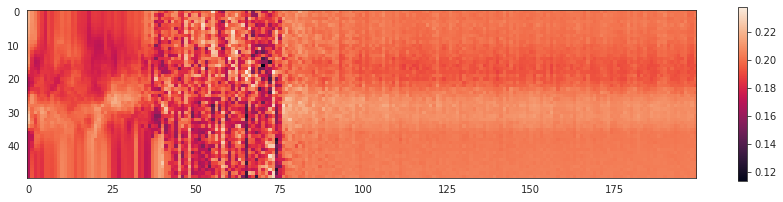

In [20]:
plt.figure(figsize=(15, 8))
plt.imshow(r_all)
plt.colorbar(shrink=0.4)
plt.show()

In [21]:
a, b = np.unravel_index(np.argmax(r_all), r_all.shape)
best_reg = regs[a]
best_cc = num_ccs[b]
best_reg, best_cc, r_all[a, b]

(7.196856730011529e-06, 61, 0.237363356073986)

In [22]:
cca = rcca.CCA(
    kernelcca=True,
    ktype='linear',
    reg=best_reg,
    numCC=best_cc,
    verbose=False,
)
cca.train([item / np.sqrt(best_cc) for item in train_list])
testcorrs = cca.validate(test_list)

corrs = []
for item in testcorrs:
    corrs.append(np.mean(np.abs(item)))
pred_r = np.mean(corrs)
pred_r

0.237363356073986

In [23]:
[item.std() for item in cca.comps]

[1.6630387121196004,
 1.0370830669429263,
 0.8260185498395596,
 2.5493738992556274,
 0.5372171099457266]

In [24]:
[item.std() for item in cca.ws]

[1.8726140133461013,
 1.3551359859386056,
 1.1047507986811718,
 2.869399226207665,
 0.7426910639777352]

In [25]:
x_trn = [x @ w for x, w in zip(train_list, cca.ws)]
x_tst = [x @ w for x, w in zip(test_list, cca.ws)]
x_trn, x_tst = tuple(map(np.concatenate, [x_trn, x_tst]))
x_trn.shape, x_tst.shape

((405, 61), (95, 61))

In [26]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

In [27]:
mcc_list = []

clf_regs = np.logspace(-3, -1, 2000)

for C in clf_regs:
    clf = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',
        max_iter=1000,
        random_state=42,
    ).fit(x_trn, y_trn)
    y_pred = clf.predict(x_tst)

    balacc = balanced_accuracy_score(y_tst, y_pred)
    mcc = matthews_corrcoef(y_tst, y_pred)
    mcc_list.append(mcc)
    # print(C, balacc, mcc)

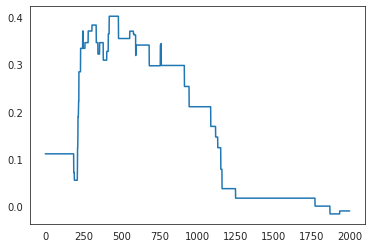

In [28]:
plt.plot(mcc_list)

In [29]:
idx = np.argmax(mcc_list)
idx, mcc_list[idx], clf_regs[idx]

(420, 0.4017929668195374, 0.0026315407833233237)

## Lessons learned:

1) Normalizing, both local, and global, helps CCA<br>
2) Normalizing helps clf as well

In [30]:
best_clf_reg = 0.0026285113395346014

clf = LogisticRegression(
    penalty='l1',
    C=best_clf_reg,
    solver='liblinear',
    max_iter=10000,
    random_state=42,
).fit(x_trn, y_trn)
y_pred = clf.predict(x_tst)

balacc = balanced_accuracy_score(y_tst, y_pred)
mcc = matthews_corrcoef(y_tst, y_pred)

balacc, mcc

(0.7000891265597148, 0.4017929668195374)

In [31]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [32]:
from tqdm.notebook import tqdm

In [33]:
raw_data = _load_target_nontarget(dirs_dict['h_load_file'])

### TODO: 

- it seems like normalizing, both globally and locally helps CCA.  But do you need to normalize in CLF as well?
- run a test below and find out. you have comparison point for when things were normalized, not run CCA with nromalized, but add another paragraph to regenerate data trn test etc without normalization and feed that into clf! see if this helps. Porbably will not tho

In [ ]:
results = pd.DataFrame()

trange = range(45, 46)

xv_folds = 5
n_seeds = 3
seeds = [int(2**i) for i in range(n_seeds)]
# num_ccs = np.arange(1, 101, 2)
# cca_regs = np.logspace(-3, -1.5, num=16) # good!
# clf_regs = np.logspace(-3, -1.4, num=17) # good!
num_ccs = np.arange(1, 201, 2)
cca_regs = np.logspace(-3, -1.5, num=20) # good!
clf_regs = np.logspace(-3, -1.4, num=20) # good!

for random_state in tqdm(seeds):
    np.random.seed(random_state)
    random.seed(random_state)
    
    for fold in tqdm(range(xv_folds), leave=False):
        trn, tst = prepare_data(
            raw_data=raw_data,
            target=True,
            normalize=True,
            xv_folds=xv_folds,
            which_fold=fold,
            time_range=trange,
            verbose=False,
        )
        train_list, y_trn, test_list, y_tst = _get_xy(trn, tst)
        
        for n_components in tqdm(num_ccs, leave=False):
            for reg in tqdm(cca_regs, leave=False):
                cca = rcca.CCA(
                    kernelcca=True,
                    ktype='linear',
                    reg=reg,
                    numCC=n_components,
                    verbose=False,
                )
                cca.train([item / np.sqrt(n_components) for item in train_list])
                testcorrs = cca.validate(test_list)

                corrs = []
                for item in testcorrs:
                    corrs.append(np.mean(np.abs(item)))
                pred_r = np.mean(corrs)

                x_trn = [x @ w for x, w in zip(train_list, cca.ws)]
                x_tst = [x @ w for x, w in zip(test_list, cca.ws)]
                x_trn, x_tst = tuple(map(np.concatenate, [x_trn, x_tst]))

                for C in clf_regs:
                    clf = LogisticRegression(
                        random_state=random_state,
                        penalty='l1',
                        C=C,
                        solver='liblinear',
                        max_iter=int(1e3),
                    ).fit(x_trn, y_trn)
                    y_pred = clf.predict(x_tst)

                    balacc = balanced_accuracy_score(y_tst, y_pred)
                    mcc = matthews_corrcoef(y_tst, y_pred)

                    data_dict = {
                        'seed': [random_state] * 3,
                        'fold': [fold] * 3,
                        'n_components': [n_components] * 3,
                        'cca_reg': [reg] * 3,
                        'clf_reg': [C] * 3,
                        'metric': ['mcc', 'bal_acc', 'pred_r'],
                        'value': [mcc, balacc, pred_r],
                    }
                    results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)
results.to_pickle('./results_night.df')

In [ ]:
best_nc = -1
best_cca_reg = -1
best_clf_reg = -1
best_score = -1

mcc_df = results.loc[results.metric == 'mcc']

for cca_reg in results.cca_reg.unique():
    for clf_reg in results.clf_reg.unique():
        for n_comps in results.n_components.unique():
            _df = mcc_df.loc[(mcc_df.cca_reg == cca_reg) &
                             (mcc_df.clf_reg == clf_reg) &
                             (mcc_df.n_components == n_comps)]
            current_score = _df.value.mean()
            if current_score >= best_score:
                best_score = current_score
                best_cca_reg = cca_reg
                best_clf_reg = clf_reg
                best_nc = n_comps

best_nc, best_cca_reg, best_clf_reg, best_score

In [67]:
(79, 0.01, 0.003981071705534973, 0.5779095104683301)

(79, 0.01, 0.003981071705534973, 0.5779095104683301)

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(9, 7))

selected_df = results.loc[(results.cca_reg == best_cca_reg) & (results.clf_reg == best_clf_reg)]

sns.lineplot(data=selected_df, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)

plt.axvline(best_nc, ls=':', color='k', alpha=0.7)

msg = '# CCA componens vs. mcc, balanced accuracy, and pred correlations\n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) balanced accuracy = {:.3f}'
avg_mcc = selected_df.loc[(selected_df.metric == 'mcc') &
                          (selected_df.n_components == best_nc)].value.mean()
avg_balacc = selected_df.loc[(selected_df.metric == 'bal_acc') &
                             (selected_df.n_components == best_nc)].value.mean()
msg = msg.format(best_nc, avg_mcc, avg_balacc)
plt.suptitle(msg, fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

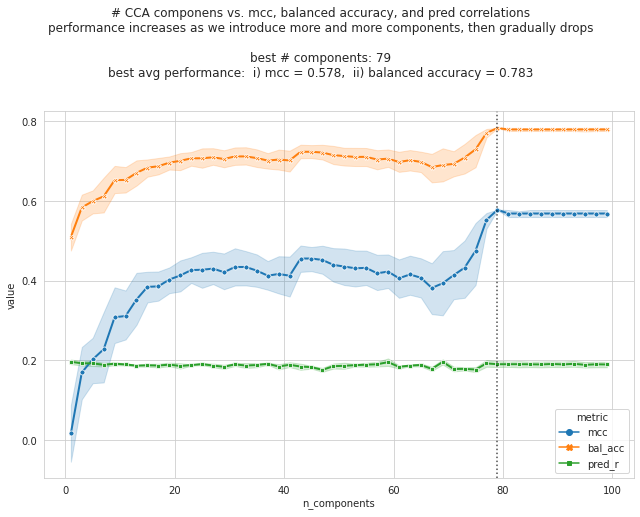

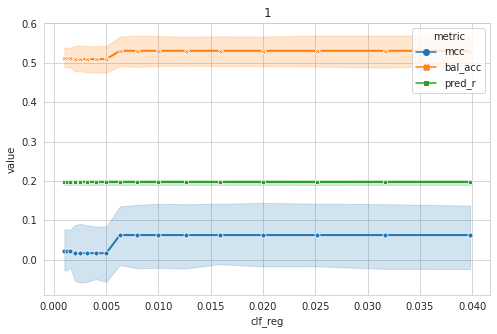

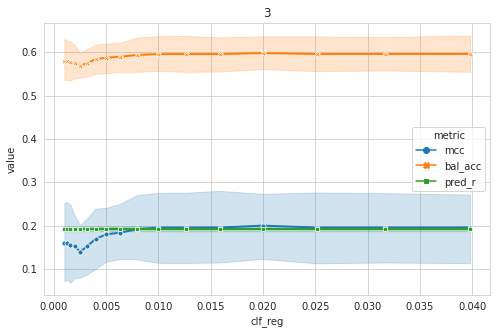

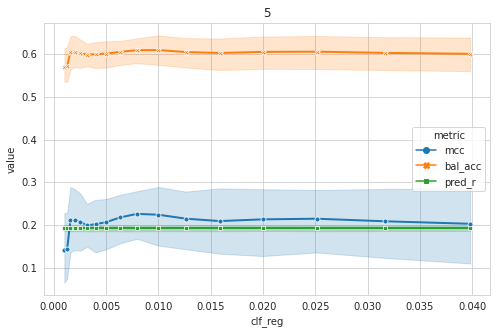

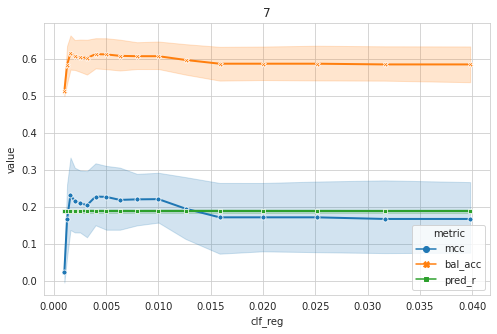

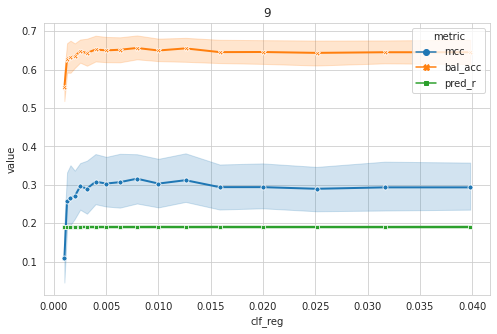

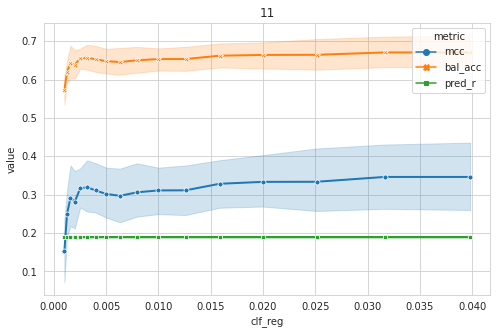

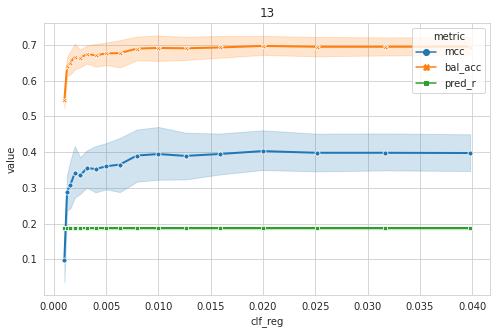

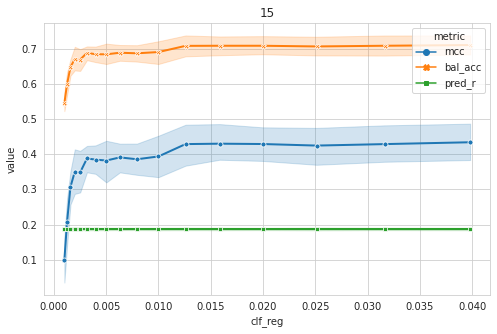

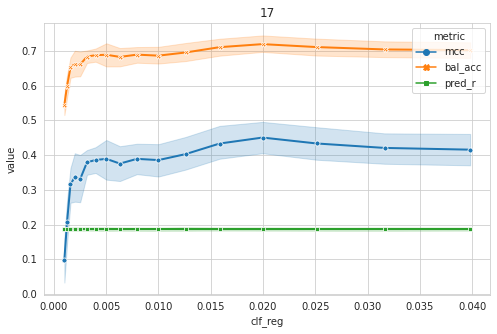

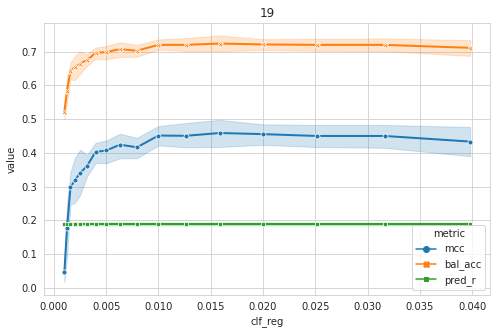

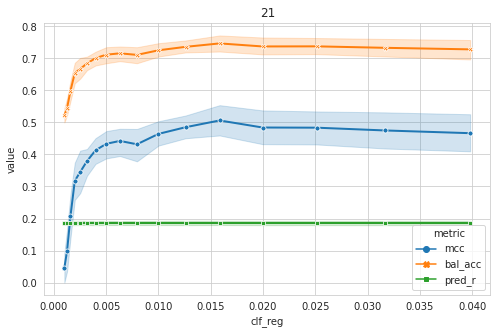

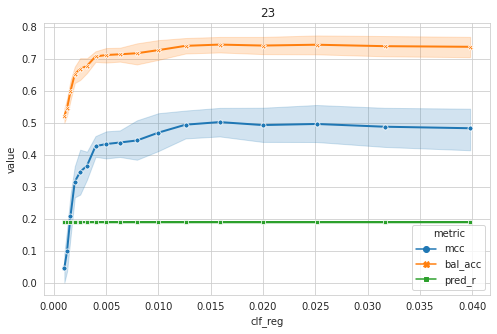

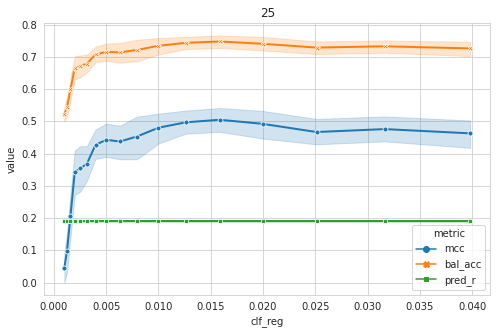

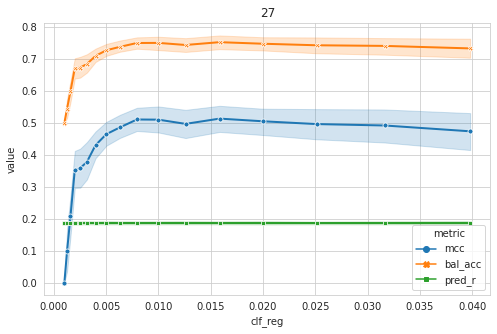

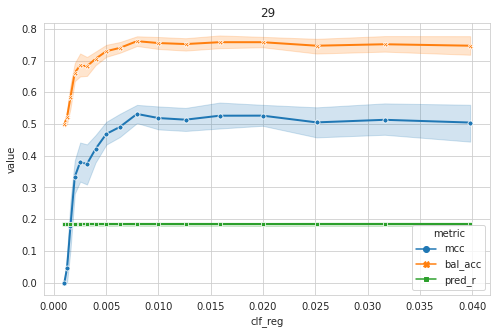

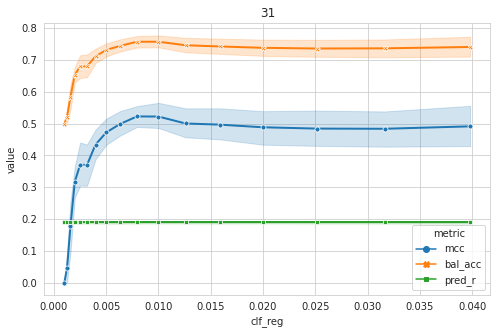

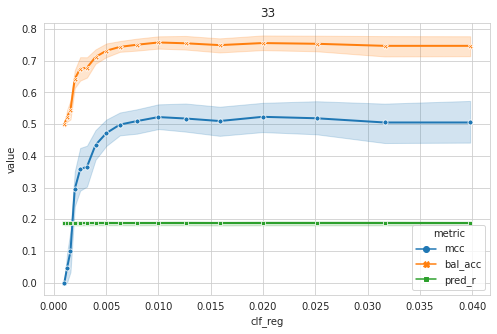

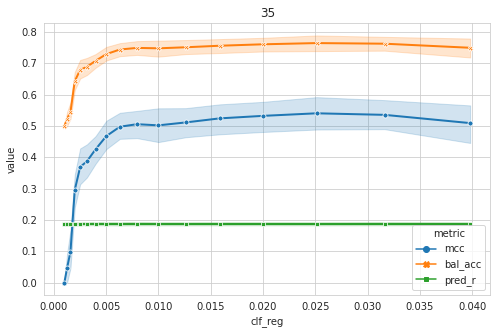

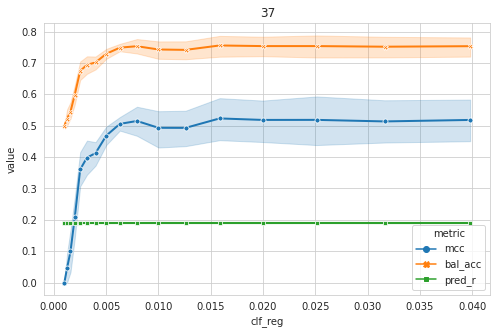

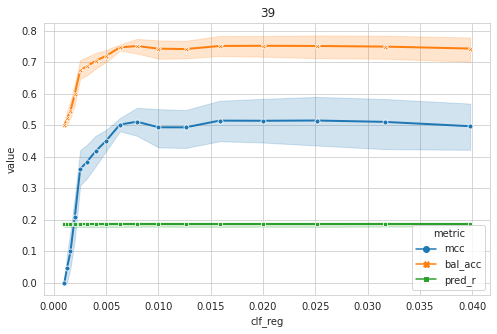

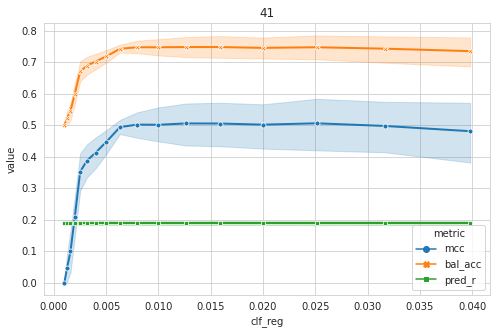

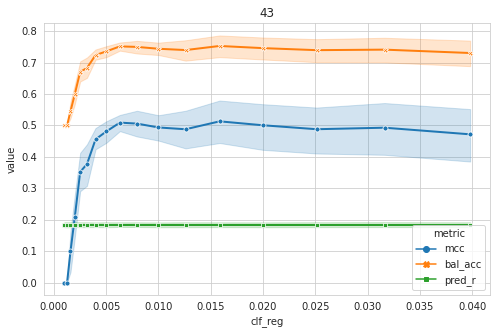

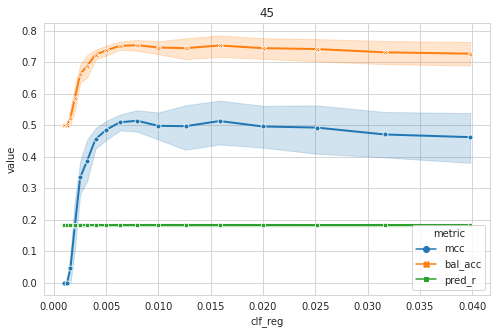

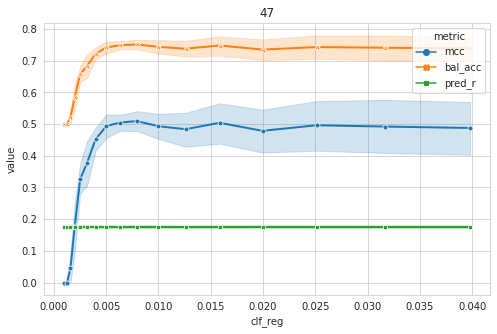

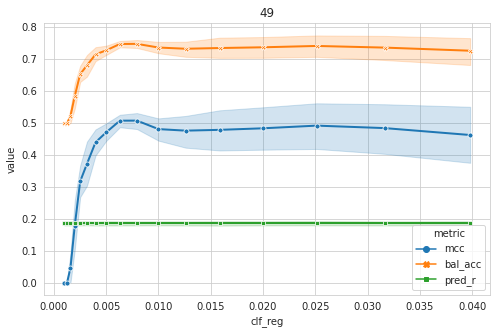

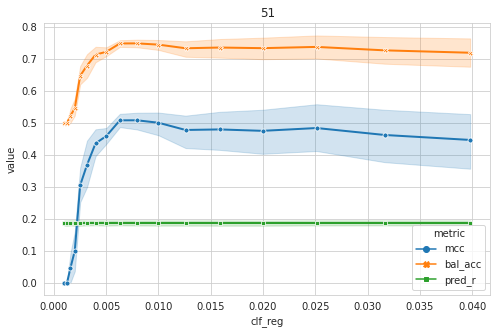

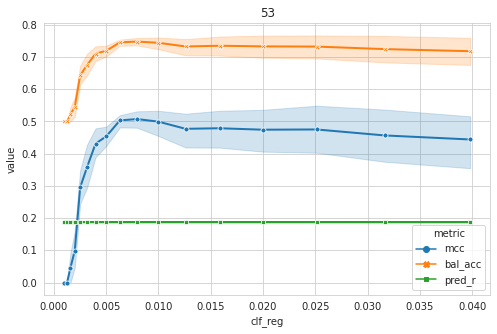

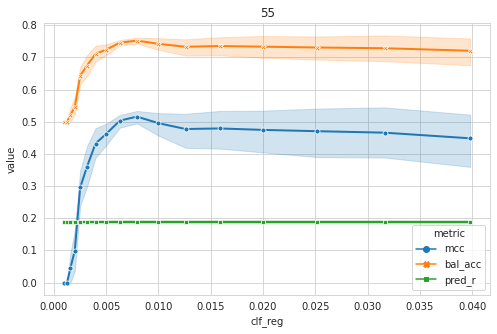

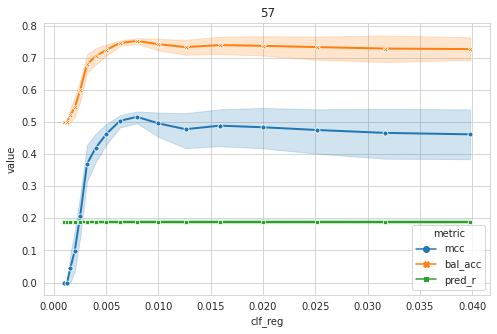

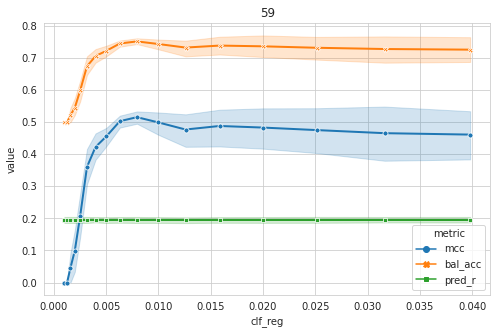

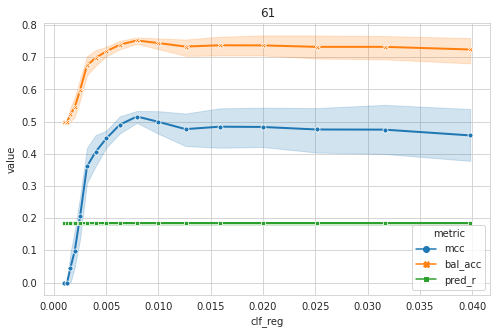

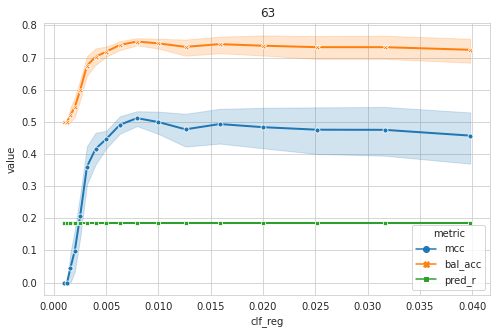

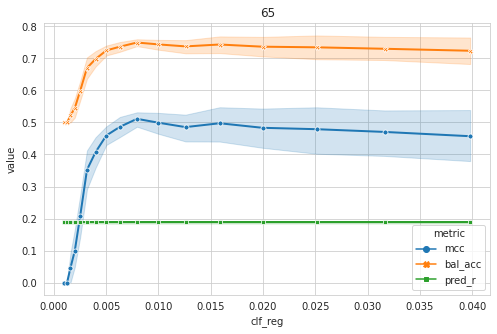

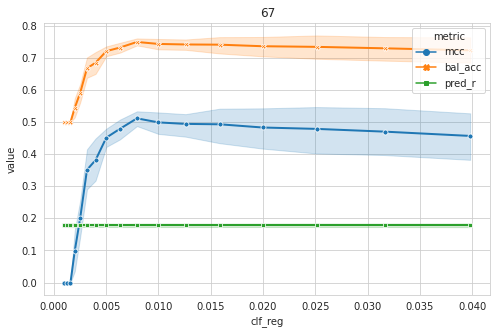

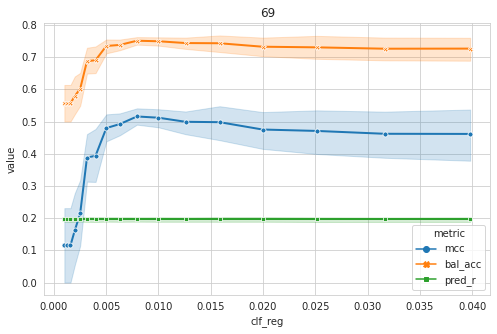

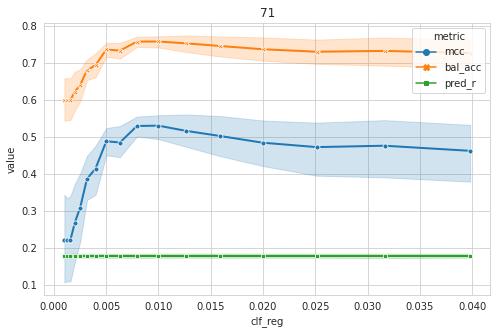

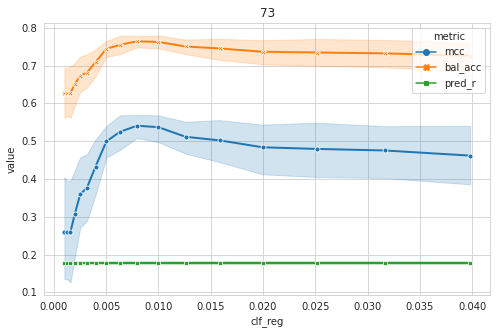

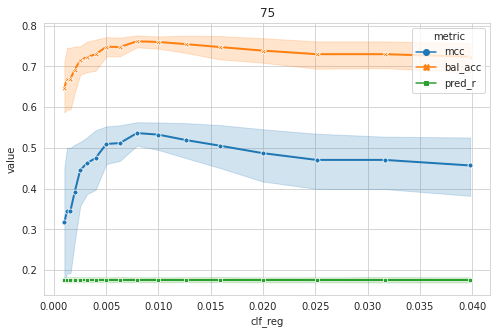

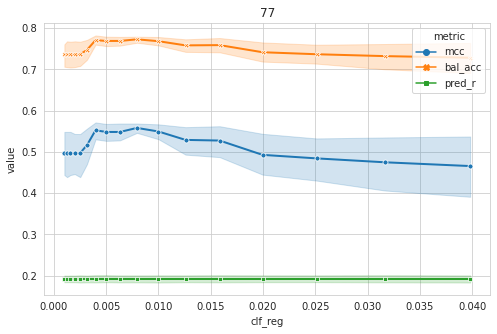

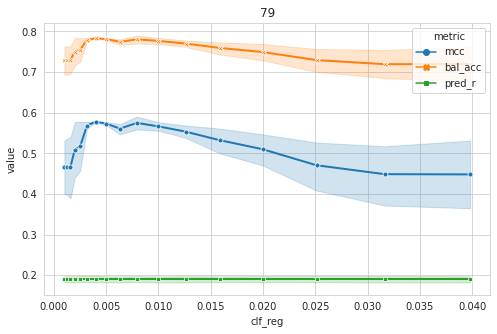

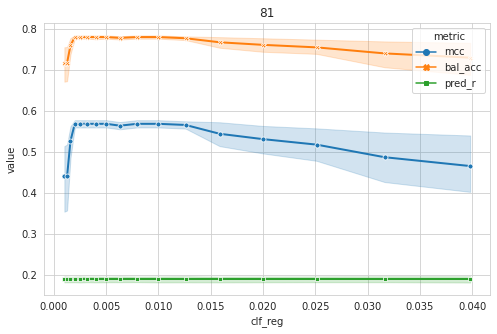

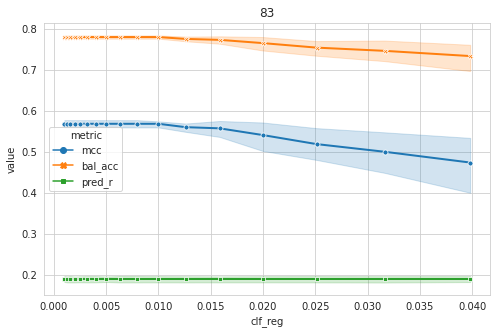

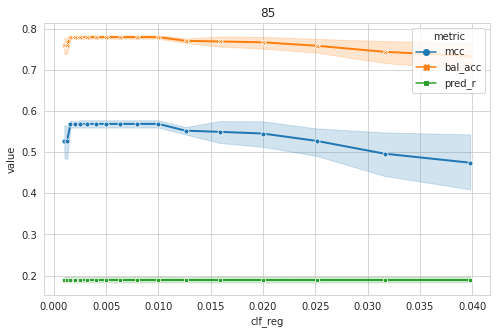

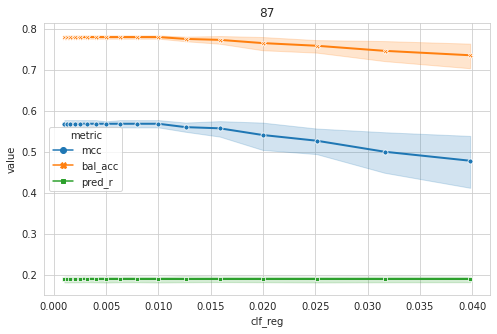

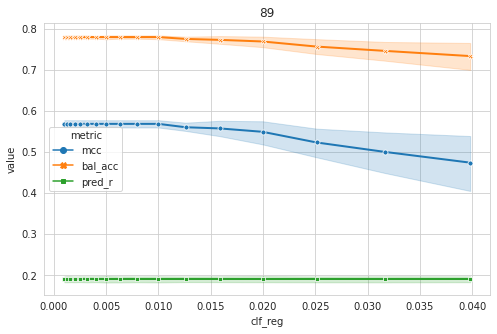

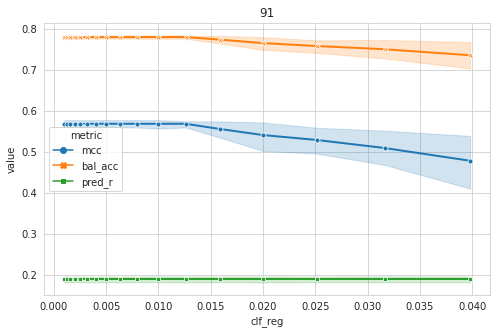

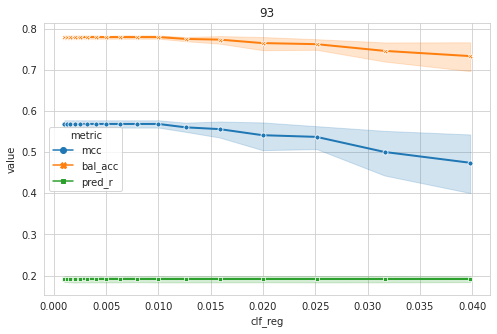

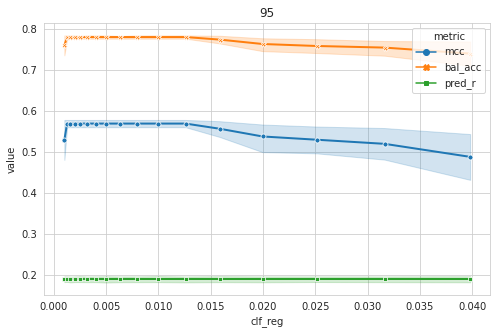

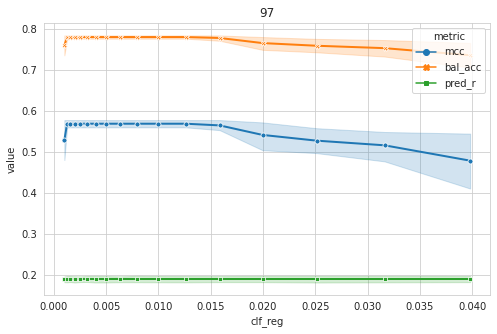

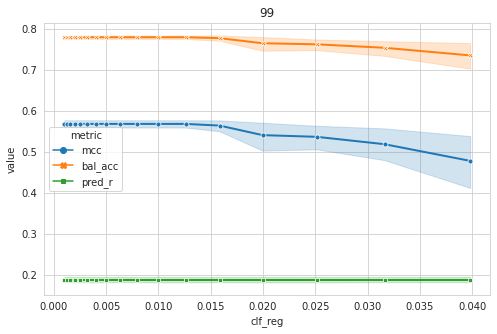

In [64]:
for cc in results.n_components.unique():
    selected_df = results.loc[(results.n_components == cc) & (results.cca_reg == best_cca_reg)]
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=selected_df, x='clf_reg', y='value', hue='metric',
                 style='metric', markers=True, dashes=False, lw=2, markersize=5)
    plt.title(cc)
    plt.show()

array([0.001     , 0.00121398, 0.00147374, 0.00178909, 0.00217191,
       0.00263665, 0.00320083, 0.00388574, 0.0047172 , 0.00572657,
       0.00695193, 0.00843948, 0.01024534, 0.01243761, 0.01509897,
       0.01832981, 0.02225197, 0.02701338, 0.03279363, 0.03981072])

seed                      1
fold                      1
n_components             23
cca_reg         0.000215443
clf_reg           0.0189574
metric                  mcc
value              0.666918
Name: 15363, dtype: object

In [69]:
selected_df = results.loc[(results.cca_reg == best_cca_reg) & (results.clf_reg == best_clf_reg)]
selected_df

,seed,fold,n_components,cca_reg,clf_reg,metric,value
63,1,0,1,0.000215,0.018957,mcc,0.340887
64,1,0,1,0.000215,0.018957,bal_acc,0.664884
65,1,0,1,0.000215,0.018957,pred_r,0.167576
363,1,0,3,0.000215,0.018957,mcc,0.285779
364,1,0,3,0.000215,0.018957,bal_acc,0.643271
...,...,...,...,...,...,...,...
179464,4,4,77,0.000215,0.018957,bal_acc,0.783645
179465,4,4,77,0.000215,0.018957,pred_r,0.201266
179763,4,4,79,0.000215,0.018957,mcc,0.577415
179764,4,4,79,0.000215,0.018957,bal_acc,0.783645


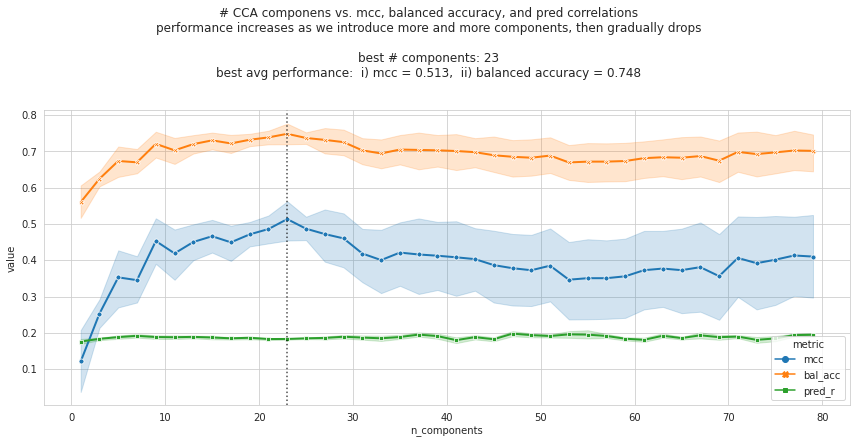

### TODO:

- first find best regs and see the effect of num components in that same reg
- then find effect of reg and nc in 2d (one for cca reg and other for clf reg)

In [89]:
_df = results.loc[(results.n_components == 5) & (results.metric == 'pred_r')]
_df

,seed,fold,n_components,cca_reg,clf_reg,metric,value
602,1,0,5,0.00001,0.010000,pred_r,0.178990
605,1,0,5,0.00001,0.018957,pred_r,0.178990
608,1,0,5,0.00001,0.035938,pred_r,0.178990
611,1,0,5,0.00001,0.068129,pred_r,0.178990
614,1,0,5,0.00001,0.129155,pred_r,0.178990
...,...,...,...,...,...,...,...
168887,4,4,5,10.00000,0.244844,pred_r,0.186055
168890,4,4,5,10.00000,0.464159,pred_r,0.186055
168893,4,4,5,10.00000,0.879923,pred_r,0.186055
168896,4,4,5,10.00000,1.668101,pred_r,0.186055


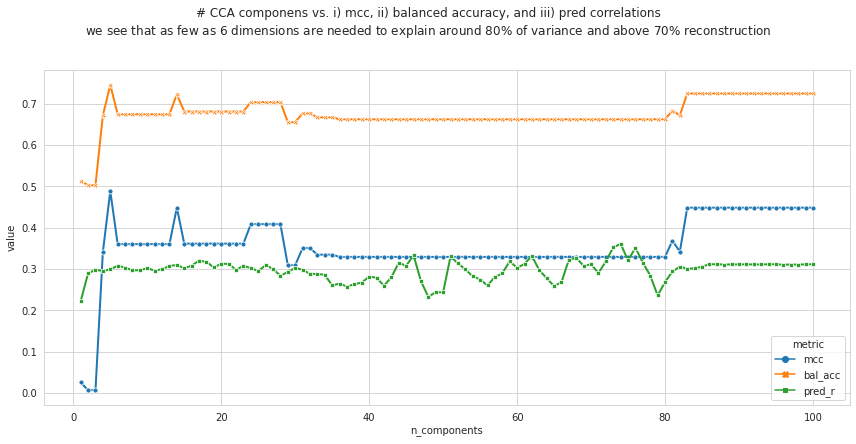

In [24]:
selected_df = results.loc[results.metric == 'mcc']
top = selected_df.value.argsort()[::-1].tolist()
selected_df.iloc[top[0]]

n_components          39
metric               mcc
value           0.733504
Name: 114, dtype: object

In [25]:
results.loc[results.n_components == 39]

,n_components,metric,value
114,39,mcc,0.733504
115,39,balacc,0.870445
116,39,ev,0.553692


In [38]:
n_components = 29
cca = rcca.CCA(kernelcca=True, ktype='linear', reg=1., numCC=n_components, verbose=False)
cca.train(list(train_data.values()))

x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
y_trn = [item for item in train_labels.values()]
y_tst = [item for item in test_labels.values()]
x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

clf = LogisticRegression(
    random_state=42,
    penalty='l1',
    # C=0.291,
    C=1.0,
    solver='liblinear',
    max_iter=int(1e6),
).fit(x_trn, y_trn)
y_pred = clf.predict(x_tst)

balacc = balanced_accuracy_score(y_tst, y_pred)
mcc = matthews_corrcoef(y_tst, y_pred)

balacc, mcc

(0.8704453441295547, 0.7335037571219197)

In [4]:


def augment_data(
    x: np.ndarray,
    y: np.ndarray,
    nb_end_samples: int,
    sigma: float = 1.0,
    rng: np.random.RandomState = None,):
    
    nb_samples, nb_features = x.shape

    if nb_end_samples - nb_samples <= 0:
        output = {
            'x_aug': x[:nb_end_samples],
            'y_aug': y[:nb_end_samples],
            'noise': None,
            'indxs': None,
        }
        return output
    else:
        nb_repeats, nb_extra_samples = nb_end_samples//nb_samples, nb_end_samples%nb_samples

    indxs = np.arange(nb_samples)
    x_aug, y_aug = tuple(map(dc, [x, y]))

    for _ in range(1, nb_repeats):
        indxs = np.concatenate([indxs, np.arange(nb_samples)])
        x_aug = np.concatenate([x_aug, x])
        y_aug = np.concatenate([y_aug, y])

    rng = np.random.RandomState(42) if rng is None else rng
    if nb_extra_samples > 0:
        extra_indxs = rng.choice(range(nb_samples), size=nb_extra_samples, replace=True)
        indxs = np.concatenate([indxs, extra_indxs])
        x_aug = np.concatenate([x_aug, x[extra_indxs]])
        y_aug = np.concatenate([y_aug, y[extra_indxs]])

    noise = np.random.randn(*x_aug.shape) * x.std(0) * sigma
    noise[:nb_samples] = 0.0

    augmented = {
        'x_aug': x_aug + noise,
        'y_aug': y_aug,
        'noise': noise,
        'indxs': indxs,
    }
    return augmented

    
def prepare_data(
    h_load_file: str,
    timepoint: int = 45,
    nb_min_samples: int = -1,
    nb_end_samples: int = None,
    augment: bool = False,
    sigma: float = 0.0,
    xv_folds: int = 10,
    random_state: int = 42,):
    
    raw_data = _load_target_nontarget(h_load_file)
    rng = np.random.RandomState(random_state)
    
    train_data, test_data = {}, {}
    train_labels, test_labels = {}, {}
    for key, val in raw_data['target_dffs'].items():
        x = val[timepoint]
        num_samples = len(x)
        if num_samples < nb_min_samples:
            continue

        labels = raw_data['target_labels'][key]
        if not augment:
            x = x[:nb_min_samples]
            labels = labels[:nb_min_samples]

        ### TODDO: floor or ceil?
            
        pos_indxs = np.where(labels == 0)[0]
        neg_indxs = np.where(labels == 1)[0]
        pos_tst_indxs = rng.choice(pos_indxs, size=int(np.ceil(len(pos_indxs)/xv_folds)), replace=False)
        neg_tst_indxs = rng.choice(neg_indxs, size=int(np.ceil(len(neg_indxs)/xv_folds)), replace=False)
        tst_indxs = np.concatenate([pos_tst_indxs, neg_tst_indxs])
        trn_indxs = np.delete(range(len(labels)), tst_indxs)
        assert not set(tst_indxs).intersection(set(trn_indxs))

        test_data[key] = x[tst_indxs]
        train_data[key] = x[trn_indxs]
        test_labels[key] = labels[tst_indxs]
        train_labels[key] = labels[trn_indxs]
    
    aug_train_data = {}
    aug_train_labels = {}
    if augment:
        for key, x in train_data.items():
            y = train_labels[key]
            augmented = augment_data(
                x=x,
                y=y,
                nb_end_samples=nb_end_samples,
                sigma=sigma,
                rng=rng,
            )
            aug_train_data[key] = augmented['x_aug']
            aug_train_labels[key] = augmented['y_aug']
    
    output = {
        'aug_train_data': aug_train_data,
        'aug_train_labels': aug_train_labels,
        'train_data': train_data,
        'train_labels': train_labels,
        'test_data': test_data,
        'test_labels': test_labels,
    }
    return output

In [18]:
[item.shape for item in a['target_freqs'].values()]

[(23,),
 (30,),
 (75,),
 (84,),
 (60,),
 (73,),
 (68,),
 (19,),
 (12,),
 (41,),
 (25,),
 (28,),
 (65,),
 (84,),
 (18,),
 (70,),
 (21,),
 (74,),
 (62,),
 (38,),
 (31,),
 (23,),
 (43,),
 (49,),
 (33,),
 (30,),
 (68,),
 (73,),
 (62,),
 (100,),
 (124,),
 (133,),
 (110,),
 (134,)]

In [3]:
import rcca
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

import random
from tqdm.notebook import tqdm

In [4]:
max_components = 100
seeds = [np.power(2, i) for i in range(30)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=False,
        nb_min_samples=100,
        random_state=seed,
    )
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(train_data.values()))
        ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 4,
            'sigma': [np.nan] * 4,
            'n_components': [n_components] * 4,
            'metric': ['mcc', 'f1', 'balacc', 'ev'],
            'value': [mcc, balacc, f1, np.mean([item.max(0).mean() for item in ev])],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

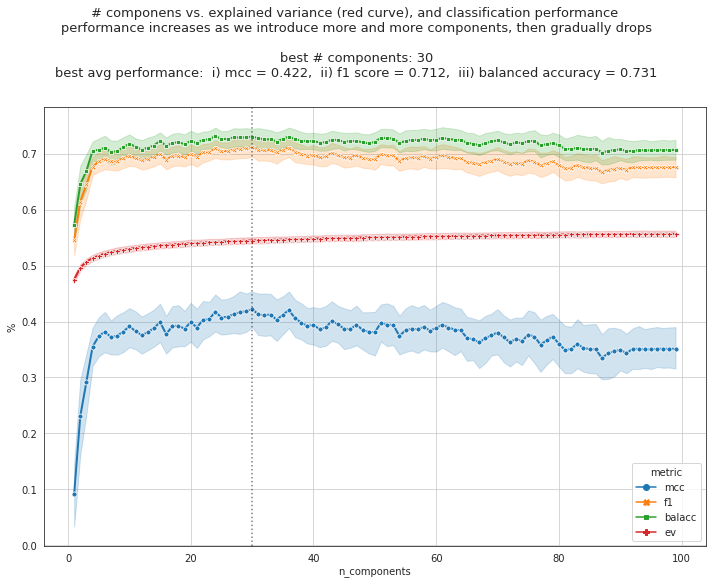

In [5]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [6]:
selected_df

,seed,sigma,n_components,metric,value
116,1,NaN,30,mcc,0.382679
512,2,NaN,30,mcc,0.478061
908,4,NaN,30,mcc,0.488662
1304,8,NaN,30,mcc,0.368924
1700,16,NaN,30,mcc,0.382679
2096,32,NaN,30,mcc,0.392532
2492,64,NaN,30,mcc,0.482527
2888,128,NaN,30,mcc,0.448464
3284,256,NaN,30,mcc,0.309343
3680,512,NaN,30,mcc,0.341797


### now aug

In [7]:
max_components = 40
seeds = [np.power(2, i) for i in range(30)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=True,
        sigma=0.3,
        nb_end_samples=130,
        nb_min_samples=100,
        random_state=seed,
    )
    aug_train_data = output['aug_train_data']
    # aug_train_labels = output['aug_train_labels']
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(aug_train_data.values()))
        # ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 3,
            'sigma': [np.nan] * 3,
            'n_components': [n_components] * 3,
            'metric': ['mcc', 'f1', 'balacc'],
            'value': [mcc, balacc, f1],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

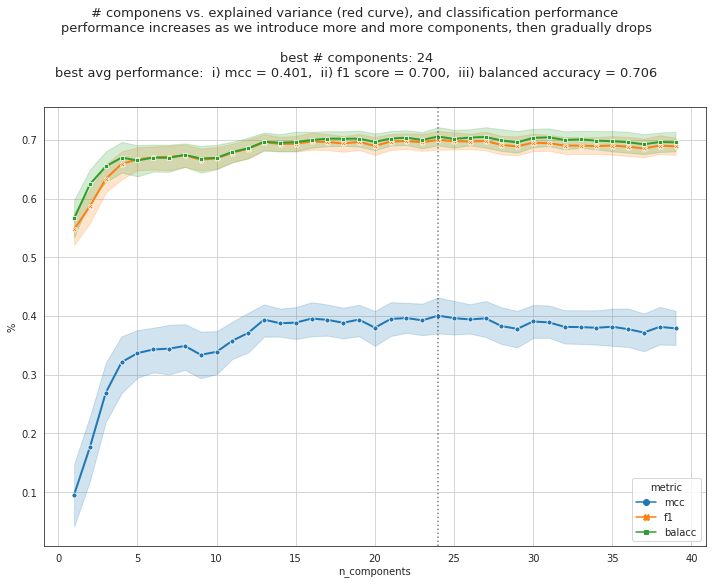

In [8]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [9]:
selected_df

,seed,sigma,n_components,metric,value
69,1,NaN,24,mcc,0.288944
186,2,NaN,24,mcc,0.432512
303,4,NaN,24,mcc,0.513300
420,8,NaN,24,mcc,0.269125
537,16,NaN,24,mcc,0.316980
654,32,NaN,24,mcc,0.465849
771,64,NaN,24,mcc,0.379787
888,128,NaN,24,mcc,0.470824
1005,256,NaN,24,mcc,0.459796
1122,512,NaN,24,mcc,0.396239


### more aug

In [10]:
max_components = 40
seeds = [np.power(2, i) for i in range(30)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=True,
        sigma=0.3,
        nb_end_samples=300,
        nb_min_samples=100,
        random_state=seed,
    )
    aug_train_data = output['aug_train_data']
    # aug_train_labels = output['aug_train_labels']
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(aug_train_data.values()))
        ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 4,
            'sigma': [np.nan] * 4,
            'n_components': [n_components] * 4,
            'metric': ['mcc', 'f1', 'balacc', 'ev'],
            'value': [mcc, balacc, f1, np.mean([item.max(0).mean() for item in ev])],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

/usr/local/lib/python3.8/dist-packages/rcca/__init__.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ccomp = np.array(ccomp)


ValueError: operands could not be broadcast together with shapes (13,1) (14,1) 

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
selected_df

### more aug / all data

In [18]:
max_components = 40
seeds = [np.power(2, i) for i in range(20)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=True,
        sigma=0.3,
        nb_end_samples=150,
        nb_min_samples=30,
        random_state=seed,
    )
    aug_train_data = output['aug_train_data']
    # aug_train_labels = output['aug_train_labels']
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(aug_train_data.values()))
        # ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 3,
            'sigma': [np.nan] * 3,
            'n_components': [n_components] * 3,
            'metric': ['mcc', 'f1', 'balacc'],
            'value': [mcc, balacc, f1],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

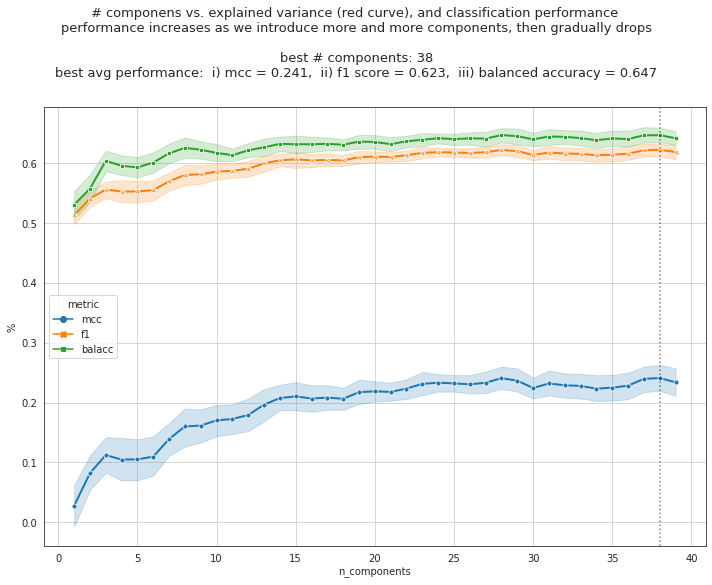

In [19]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [20]:
selected_df

,seed,sigma,n_components,metric,value
111,1,NaN,38,mcc,0.196640
228,2,NaN,38,mcc,0.168664
345,4,NaN,38,mcc,0.216517
462,8,NaN,38,mcc,0.273217
579,16,NaN,38,mcc,0.252466
696,32,NaN,38,mcc,0.315904
813,64,NaN,38,mcc,0.208521
930,128,NaN,38,mcc,0.164668
1047,256,NaN,38,mcc,0.208509
1164,512,NaN,38,mcc,0.260438


## Discussion
### ???